In [1]:
# list datasets for yack
from rouskinhf import *
import pandas as pd

DATASETS = ['bpRNA','RNAstralign','archiveII']

data = pd.DataFrame()
for name in DATASETS:
    ds = pd.DataFrame.from_dict(get_dataset(name), orient='index')
    ds['dataset'] = name
    data = pd.concat([data, ds], axis=0)  
      
data.reset_index(inplace=True)
data.rename(columns={'index': 'reference'}, inplace=True)

In [2]:
# remove sequences below 10nt 
print("Remove {} sequences below 10nt".format((data['sequence'].str.len() < 10).sum()))
data = data[data['sequence'].str.len() >= 10]

# remove sequences with no structure
print("Remove {} sequences with no structure".format((data['structure'].str.len() == 0).sum()))
data = data[data['structure'].str.len() > 0]

# rename non-unique references
for i, group in data.groupby('reference'):
    if len(group) > 1:
        for j, row in group.iterrows():
            data.loc[j, 'reference'] = row['reference'] + '__' + str(j)

assert len(data['reference'].unique()) == len(data)

data.set_index('reference', inplace=True)
dump_json(data.to_dict(orient='index'), 'datasets.json')
print("Saved {} sequences to datasets.json".format(len(data)))

Remove 28 sequences below 10nt
Remove 392 sequences with no structure
Saved 96863 sequences to datasets.json


In [3]:
data.value_counts('dataset')

dataset
bpRNA          66302
RNAstralign    27079
archiveII       3482
Name: count, dtype: int64

In [4]:
len(data['sequence'].unique())

79051

In [5]:
# count the double sequences 
import tqdm 
import numpy as np
count = {}
venn_data = {ds: set() for ds in DATASETS}
for seq, group in tqdm.tqdm(data.groupby('sequence'), total = len(data['sequence'].unique())):
    dss = tuple(np.sort(group['dataset'].unique()))

    for ds in dss:
        venn_data[ds].add(seq)
    




100%|██████████| 79051/79051 [00:02<00:00, 35772.93it/s]


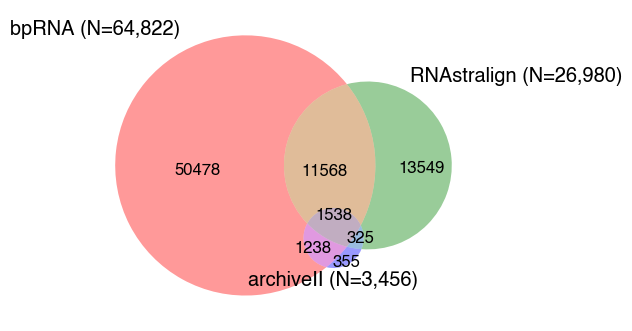

In [14]:
# make a venn diagram of the datasets
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import numpy as np

# use helvetica font
plt.rcParams['font.family'] = 'helvetica'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(5,5))
venn3([venn_data[ds] for ds in DATASETS], [d + ' (N={:,})'.format(len(venn_data[d])) for d in DATASETS])



# save to pdf
plt.savefig('images/datasets_superposition.pdf', bbox_inches='tight')